In [17]:
# Cell 1
import pandas as pd
import numpy as np
import torch
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import gc
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=UserWarning)

# Add src to path to load our custom Asymmetric model
sys.path.append('../src')
from model import MultiTaskTabNet

In [18]:
# Cell 2
# We use the same 'train.parquet' but focus on the Validation split
df = pd.read_parquet('../data/processed/train.parquet')

# Re-create the exact split used in training (Last 20%)
split_idx = int(len(df) * 0.8)
val_df = df.iloc[split_idx:]

# Prepare X and y
X_val = val_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1).fillna(-999)
y_val = val_df['isFraud'].values

# Cleanup to save RAM
del df, val_df
gc.collect()

3845

In [19]:
# Cell 3
# Load Model 1: LightGBM Baseline (Tree)
print("\n--- Loading LightGBM Baseline ---")
try:
    lgbm_model = lgb.Booster(model_file='../outputs/models/lgbm_baseline.txt')
    preds_lgbm = lgbm_model.predict(X_val)
    auc_lgbm = roc_auc_score(y_val, preds_lgbm)
    print(f"✅ LightGBM Loaded | AUC: {auc_lgbm:.4f}")
except Exception as e:
    print(f"❌ Error loading LightGBM: {e}")
    preds_lgbm = np.zeros(len(y_val))
    auc_lgbm = 0.5


--- Loading LightGBM Baseline ---
✅ LightGBM Loaded | AUC: 0.9852


In [20]:
# Cell 4
# Load Model 2: Standard TabNet Baseline (Neural)
print("\n--- Loading Standard TabNet ---")
try:
    # TabNet loads from a zip file
    clf = TabNetClassifier()
    clf.load_model('../outputs/models/tabnet_credit_baseline.zip')
    
    # Predict (Note: TabNet output is [Prob_0, Prob_1], we take column 1)
    preds_tabnet_std = clf.predict_proba(X_val.values)[:, 1]
    auc_tabnet_std = roc_auc_score(y_val, preds_tabnet_std)
    print(f"✅ Standard TabNet Loaded | AUC: {auc_tabnet_std:.4f}")
except Exception as e:
    print(f"❌ Error loading TabNet Baseline: {e}")
    preds_tabnet_std = np.zeros(len(y_val))
    auc_tabnet_std = 0.5


--- Loading Standard TabNet ---
✅ Standard TabNet Loaded | AUC: 0.8726


In [21]:
# Cell 5
# Load Model 3: Asymmetric MTL TabNet (Your Custom Architecture)
print("\n--- Loading Asymmetric MTL TabNet ---")
SHARED_DIM = 50 
input_dim = SHARED_DIM
private_dim = X_val.shape[1] - SHARED_DIM
device = torch.device('cpu')

model_mtl = MultiTaskTabNet(input_dim=input_dim, private_dim=private_dim)

try:
    model_mtl.load_state_dict(torch.load('../outputs/models/unified_mtl_best.pth', map_location=device))
    model_mtl.eval()
    
    # Batch Inference for Memory Safety on 16GB RAM
    X_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    batch_size = 1024
    preds_mtl = []
    
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch = X_tensor[i:i+batch_size]
            x_shared = batch[:, :SHARED_DIM]
            x_private = batch[:, SHARED_DIM:]
            
            _, f_prob = model_mtl(x_shared, x_private)
            preds_mtl.extend(f_prob.numpy().flatten())
            
    preds_mtl = np.array(preds_mtl)
    auc_mtl = roc_auc_score(y_val, preds_mtl)
    print(f"✅ Asymmetric MTL Loaded | AUC: {auc_mtl:.4f}")

except FileNotFoundError:
    print("❌ Asymmetric Model not found. Did you run src/main.py?")
    preds_mtl = np.zeros(len(y_val))
    auc_mtl = 0.5


--- Loading Asymmetric MTL TabNet ---
✅ Asymmetric MTL Loaded | AUC: 0.8256


In [22]:
# Cell 6: Stacked Ensemble (The Meta-Learner)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib  # Required for saving the model
import os

print("\n--- Training Stacked Meta-Learner ---")

# 1. Create the "Meta-Feature" Matrix
# We stack the predictions of ALL THREE models side-by-side
# Shape: (Rows, 3) -> [LightGBM, Std_TabNet, Asymmetric_MTL]
X_meta = np.column_stack((preds_lgbm, preds_tabnet_std, preds_mtl))

# 2. Split Validation Set for Stacking
# We split again to prevent the Meta-Learner from just memorizing the validation set
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_val, test_size=0.5, random_state=42, stratify=y_val
)

# 3. Train the Meta-Model (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, y_meta_train)

# 4. View the "Learned Weights" (Coefficients)
weights = meta_model.coef_[0]
print("--- Learned Ensemble Weights ---")
print(f"LightGBM:       {weights[0]:.4f}")
print(f"Std TabNet:     {weights[1]:.4f}")
print(f"Asymmetric MTL: {weights[2]:.4f}")
print(f"Bias (Intercept): {meta_model.intercept_[0]:.4f}")

# 5. SAVE THE META-MODEL (Crucial for Notebook 08)
os.makedirs('../outputs/models/', exist_ok=True)
joblib.dump(meta_model, '../outputs/models/meta_learner_logistic.pkl')
print("✅ Meta-Learner saved to ../outputs/models/meta_learner_logistic.pkl")

# 6. Evaluate on Held-Out Test Set
preds_stacked_test = meta_model.predict_proba(X_meta_test)[:, 1]
stacked_auc = roc_auc_score(y_meta_test, preds_stacked_test)
lgbm_baseline_auc = roc_auc_score(y_meta_test, X_meta_test[:, 0]) # Column 0 is LightGBM

print(f"\n--- Stacking Results (Held-Out Test Set) ---")
print(f"LightGBM Baseline: {lgbm_baseline_auc:.5f}")
print(f"Stacked Ensemble:  {stacked_auc:.5f}")
print(f"Improvement:       {((stacked_auc - lgbm_baseline_auc)/lgbm_baseline_auc)*100:.2f}%")

if stacked_auc > lgbm_baseline_auc:
    print("🚀 SUCCESS: Stacking beat the single best model!")
else:
    print("⚠️ Insight: LightGBM is dominant. The stacker is defaulting to it.")


--- Training Stacked Meta-Learner ---
--- Learned Ensemble Weights ---
LightGBM:       16.7702
Std TabNet:     -0.0032
Asymmetric MTL: -0.5650
Bias (Intercept): -5.1740
✅ Meta-Learner saved to ../outputs/models/meta_learner_logistic.pkl

--- Stacking Results (Held-Out Test Set) ---
LightGBM Baseline: 0.98269
Stacked Ensemble:  0.98242
Improvement:       -0.03%
⚠️ Insight: LightGBM is dominant. The stacker is defaulting to it.


✅ Results saved to ../outputs/ensemble_results.parquet


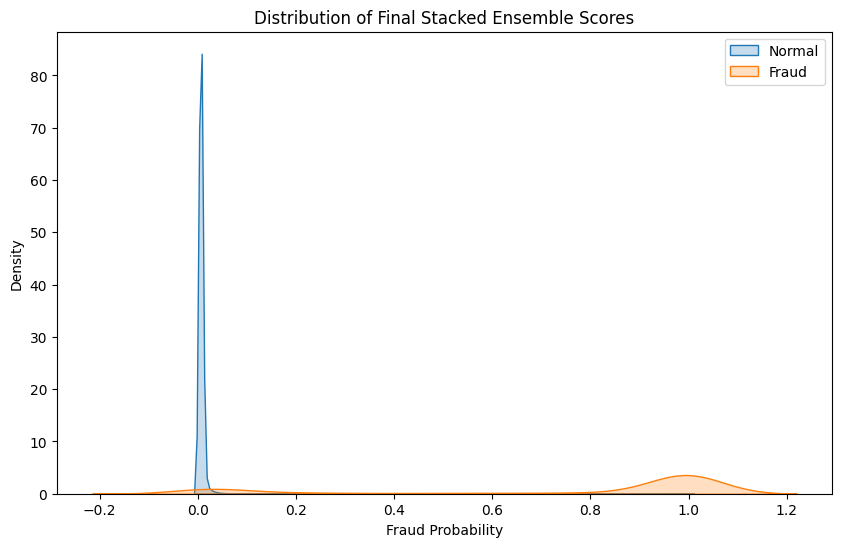

In [23]:
# Cell 7: Save & Visualize Full Results
# Generate Stacked Predictions for the FULL Validation Set (for the report)
final_preds_full = meta_model.predict_proba(X_meta)[:, 1]

# Save Results to Parquet for Notebook 07 (Evaluation)
results_df = pd.DataFrame({
    'y_true': y_val,
    'pred_lgbm': preds_lgbm,
    'pred_tabnet': preds_tabnet_std,
    'pred_mtl': preds_mtl,
    'pred_ensemble': final_preds_full
})

results_df.to_parquet('../outputs/ensemble_results.parquet')
print("✅ Results saved to ../outputs/ensemble_results.parquet")

# Quick Visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(final_preds_full[y_val == 0], label='Normal', fill=True)
sns.kdeplot(final_preds_full[y_val == 1], label='Fraud', fill=True)
plt.title('Distribution of Final Stacked Ensemble Scores')
plt.xlabel('Fraud Probability')
plt.legend()
plt.show()